# Next Product to Buy Models

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
import seaborn as sns

from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_auc_score



# increase plot resolution
# mpl.rcParams["figure.dpi"] = 150

In [2]:
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [3]:
## loading the data - this dataset must NOT be changed
pentathlon_nptb = pd.read_pickle("data/pentathlon_nptb.pkl")
pentathlon_nptb["buyer_yes"] = (pentathlon_nptb["buyer"] == "yes").astype(int)
pentathlon_nptb.head()

,custid,buyer,total_os,message,age,gender,income,education,children,freq_endurance,...,endurance_os,strength_os,water_os,team_os,backcountry_os,winter_os,racquet_os,training,representative,buyer_yes
0,U45198803,no,0.0,endurance,30 to 44,M,25000,14,1.3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2147483648,1,0
1,U22197752,no,0.0,backcountry,45 to 59,F,40000,44,0.4,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2147483648,1,0
2,U83874832,no,0.0,backcountry,45 to 59,M,50000,24,0.8,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
3,U19423462,no,0.0,winter,45 to 59,F,50000,26,1.1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2147483648,1,0
4,U23888305,no,0.0,winter,30 to 44,M,40000,22,1.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2147483648,1,0


# 1. Logit

## 1.1 Exploratory Data Analysis

### Relationship amongst features

Correlation
Variables: income, education, children, freq_endurance, freq_strength, freq_water, freq_team, freq_backcountry, freq_winter, freq_racquet
Null hyp.: variables x and y are not correlated
Alt. hyp.: variables x and y are correlated

Correlation matrix:
                 income education children freq_endurance freq_strength  \
education          0.77                                                   
children          0.167    -0.143                                         
freq_endurance    0.592      0.57    0.132                                
freq_strength     0.541     0.501    0.119          0.377                 
freq_water        0.481     0.446    0.098          0.356         0.305   
freq_team         0.472     0.431    0.108          0.334          0.31   
freq_backcountry  0.333     0.336    0.078          0.237         0.205   
freq_winter       0.283     0.263    0.058          0.194         0.171   
freq_racquet      0.548     0.552    0.118          0.387     

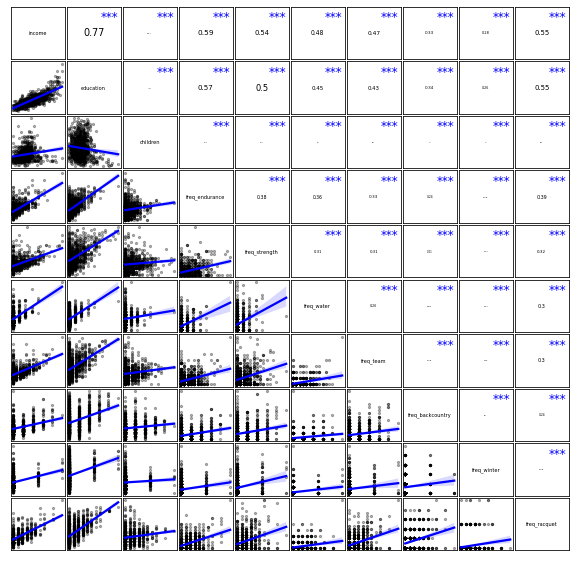

In [4]:
cor = rsm.correlation(pentathlon_nptb[['message', 'age', 'gender', 'income',
       'education', 'children', 'freq_endurance', 'freq_strength',
       'freq_water', 'freq_team', 'freq_backcountry', 'freq_winter',
       'freq_racquet']])
cor.summary(dec=3)
cor.plot()

We notice that education and income have positive high correlation, using both these will lead to multicollinearity

### Checking response rate for each message sent to customers

In [5]:
pentathlon_nptb['message'].value_counts(normalize=True)

team           0.145230
racquet        0.143610
winter         0.143505
backcountry    0.142820
water          0.142010
strength       0.141910
endurance      0.140915
Name: message, dtype: float64

Proportion of messages across 7 department are almost the same.

In [6]:
plot = pd.crosstab(pentathlon_nptb.message, pentathlon_nptb.buyer_yes,normalize='index')

#### We notice response rates for each department is similar

<AxesSubplot:xlabel='message'>

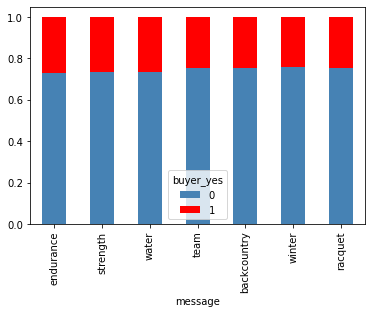

In [7]:
#create stacked bar chart
plot.plot(kind='bar', stacked=True, color=['steelblue', 'red'])

response rate in each department is almost the same

### Checking response rate for age categories

In [8]:
pentathlon_nptb['age'].value_counts(normalize=True)

45 to 59    0.340510
30 to 44    0.334360
>= 60       0.170155
< 30        0.154975
Name: age, dtype: float64

####  we find most customers fall between the ages of 30-59

In [9]:
plot = pd.crosstab(pentathlon_nptb.age, pentathlon_nptb.buyer_yes,normalize='index')

<AxesSubplot:xlabel='age'>

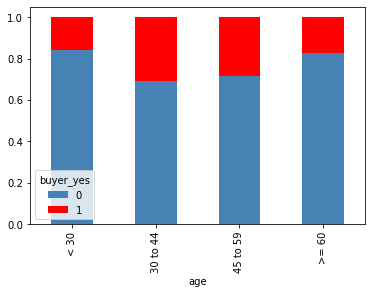

In [10]:
#create stacked bar chart
plot.plot(kind='bar', stacked=True, color=['steelblue', 'red'])

In addition, customers between 30-59 have a higher response rate. This also improves that the targeting customers are between 30-59

### gender vs response rate

In [11]:
pentathlon_nptb['gender'].value_counts(normalize=True)

M    0.61186
F    0.38814
Name: gender, dtype: float64

#### We find most customers are male

In [12]:
plot = pd.crosstab(pentathlon_nptb.gender, pentathlon_nptb.buyer_yes,normalize='index')

<AxesSubplot:xlabel='gender'>

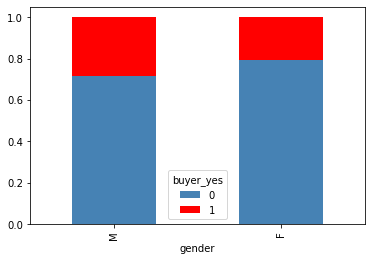

In [13]:
#create stacked bar chart
plot.plot(kind='bar', stacked=True, color=['steelblue', 'red'])

In addition, male customers have a high response rate.

In [14]:
pd.crosstab([pentathlon_nptb.gender,pentathlon_nptb.age], pentathlon_nptb.buyer_yes,normalize='index')

buyer_yes               0         1
gender age                         
M      < 30      0.834550  0.165450
       30 to 44  0.651550  0.348450
       45 to 59  0.678643  0.321357
       >= 60     0.812931  0.187069
F      < 30      0.852941  0.147059
       30 to 44  0.753181  0.246819
       45 to 59  0.769249  0.230751
       >= 60     0.850408  0.149592

no matter what gender the customer is, people between 30-59 have a high response rate.

### income vs response rate

In [15]:
# hard to interpret
plot = pentathlon_nptb['income'].value_counts(normalize=True).reset_index().sort_values(by='index')
plot['index']=(plot['index']/5000).astype('int')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23'),
  Text(24, 0, '24'),
  Text(25, 0, '25'),
  Text(26, 0, '26'),
  Text(27, 0, '27'),
  Text(28, 0, '28'),
  Text(29, 0, '29'),
  Text(30, 0, '30'),
  Text(31, 0, '31'),
  Text(32, 0, '32'),
  Text(33, 0, '33'),
  Text(34, 0, '34'),
  Text(35, 0, '35'),
  Text(36, 0, '36'),
  Text(37, 0, '37'),
  Text(38, 0, '38'),
  Text(39, 

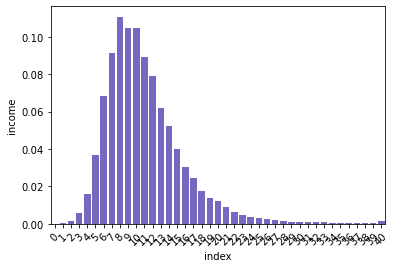

In [16]:
fig = sns.barplot(x='index', y="income", data=plot, order=plot['index'],color = 'slateblue')
plt.xticks(rotation=45)

we notice a right-skewed normal distribution

In [17]:
plot = pd.crosstab((pentathlon_nptb.income/5000).astype(int), pentathlon_nptb.buyer_yes,normalize='index').reset_index()

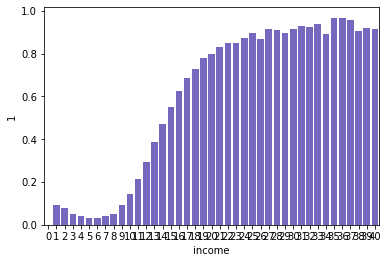

In [18]:
#create stacked bar chart
fig= sns.barplot(data = plot, x='income',y=1,color = 'slateblue')

We notice that customers with higher income have higher response rate and follows general intuition

### education vs response rate

In [19]:
# hard to interpret
plot = pentathlon_nptb['education'].value_counts(normalize=True).reset_index().sort_values(by='index')

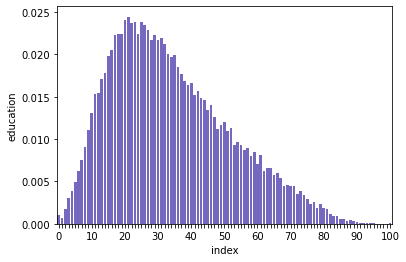

In [20]:
fig = sns.barplot(x='index', y="education", data=plot, order=plot['index'],color = 'slateblue')

for ind, label in enumerate(fig.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

we notice a right-skewed normal distribution, similar to income

In [21]:
plot = pd.crosstab(pentathlon_nptb.education, pentathlon_nptb.buyer_yes,normalize='index').reset_index()

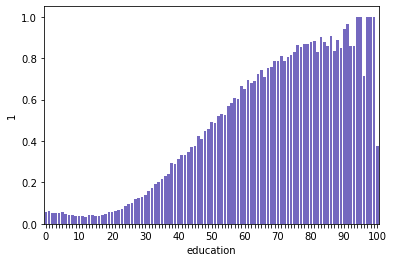

In [22]:
#create stacked bar chart
fig= sns.barplot(data = plot, x='education',y=1,color = 'slateblue')

for ind, label in enumerate(fig.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

### children vs response rate

In [23]:
plot = pentathlon_nptb['children'].value_counts(normalize=True).reset_index().sort_values(by='index')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52]),
 [Text(0, 0, '0.2'),
  Text(1, 0, '0.3'),
  Text(2, 0, '0.4'),
  Text(3, 0, '0.5'),
  Text(4, 0, '0.6'),
  Text(5, 0, '0.7'),
  Text(6, 0, '0.8'),
  Text(7, 0, '0.9'),
  Text(8, 0, '1.0'),
  Text(9, 0, '1.1'),
  Text(10, 0, '1.2'),
  Text(11, 0, '1.3'),
  Text(12, 0, '1.4'),
  Text(13, 0, '1.5'),
  Text(14, 0, '1.6'),
  Text(15, 0, '1.7'),
  Text(16, 0, '1.8'),
  Text(17, 0, '1.9'),
  Text(18, 0, '2.0'),
  Text(19, 0, '2.1'),
  Text(20, 0, '2.2'),
  Text(21, 0, '2.3'),
  Text(22, 0, '2.4'),
  Text(23, 0, '2.5'),
  Text(24, 0, '2.6'),
  Text(25, 0, '2.7'),
  Text(26, 0, '2.8'),
  Text(27, 0, '2.9'),
  Text(28, 0, '3.0'),
  Text(29, 0, '3.1'),
  Text(30, 0, '3.2'),
  Text(31, 0, '3.3'),
  Text(32, 0, '3.4'),
  Text(33, 0, '3.5'),
  Text(34, 0, '3

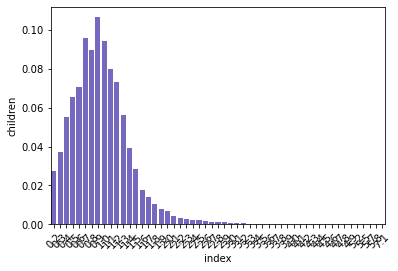

In [24]:
fig = sns.barplot(x='index', y="children", data=plot, order=plot['index'],color = 'slateblue')
plt.xticks(rotation=45)

In [25]:
plot = pd.crosstab(pentathlon_nptb.children, pentathlon_nptb.buyer_yes,normalize='index').reset_index()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52]),
 [Text(0, 0, '0.2'),
  Text(1, 0, '0.3'),
  Text(2, 0, '0.4'),
  Text(3, 0, '0.5'),
  Text(4, 0, '0.6'),
  Text(5, 0, '0.7'),
  Text(6, 0, '0.8'),
  Text(7, 0, '0.9'),
  Text(8, 0, '1.0'),
  Text(9, 0, '1.1'),
  Text(10, 0, '1.2'),
  Text(11, 0, '1.3'),
  Text(12, 0, '1.4'),
  Text(13, 0, '1.5'),
  Text(14, 0, '1.6'),
  Text(15, 0, '1.7'),
  Text(16, 0, '1.8'),
  Text(17, 0, '1.9'),
  Text(18, 0, '2.0'),
  Text(19, 0, '2.1'),
  Text(20, 0, '2.2'),
  Text(21, 0, '2.3'),
  Text(22, 0, '2.4'),
  Text(23, 0, '2.5'),
  Text(24, 0, '2.6'),
  Text(25, 0, '2.7'),
  Text(26, 0, '2.8'),
  Text(27, 0, '2.9'),
  Text(28, 0, '3.0'),
  Text(29, 0, '3.1'),
  Text(30, 0, '3.2'),
  Text(31, 0, '3.3'),
  Text(32, 0, '3.4'),
  Text(33, 0, '3.5'),
  Text(34, 0, '3

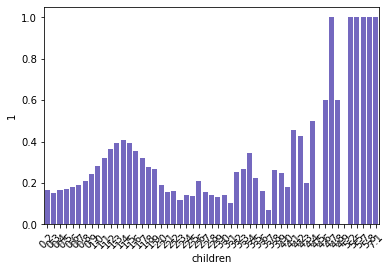

In [26]:
#create stacked bar chart
fig= sns.barplot(data = plot, x='children',y=1,color = 'slateblue')
plt.xticks(rotation=45)

We see that number of children has a direct influence on the response rate. It appears to be a feature of significance.

### frequency vs response

In [27]:
pentathlon_nptb.columns

Index(['custid', 'buyer', 'total_os', 'message', 'age', 'gender', 'income',
       'education', 'children', 'freq_endurance', 'freq_strength',
       'freq_water', 'freq_team', 'freq_backcountry', 'freq_winter',
       'freq_racquet', 'endurance_os', 'strength_os', 'water_os', 'team_os',
       'backcountry_os', 'winter_os', 'racquet_os', 'training',
       'representative', 'buyer_yes'],
      dtype='object')

In [28]:
plot = pd.crosstab(pentathlon_nptb.freq_endurance, pentathlon_nptb.buyer_yes,normalize='index').reset_index()

[Text(0.5, 1.0, 'freq_endurance')]

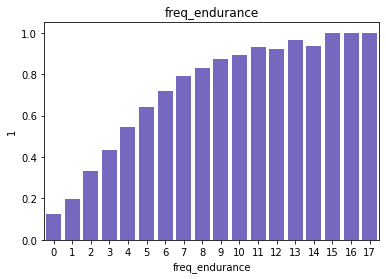

In [29]:
#create stacked bar chart
fig= sns.barplot(data = plot, x='freq_endurance',y=1,color = 'slateblue')
fig.set(title='freq_endurance')

In [30]:
plot = pd.crosstab(pentathlon_nptb.freq_strength, pentathlon_nptb.buyer_yes,normalize='index').reset_index()

[Text(0.5, 1.0, 'freq_strength')]

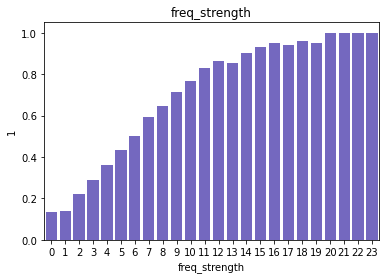

In [31]:
#create stacked bar chart
fig= sns.barplot(data = plot, x='freq_strength',y=1,color = 'slateblue')
fig.set(title='freq_strength')

In [32]:
plot = pd.crosstab(pentathlon_nptb.freq_water, pentathlon_nptb.buyer_yes,normalize='index').reset_index()

[Text(0.5, 1.0, 'freq_water')]

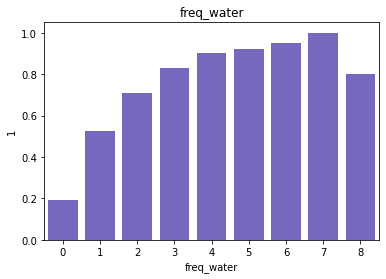

In [33]:
#create stacked bar chart
fig= sns.barplot(data = plot, x='freq_water',y=1,color = 'slateblue')
fig.set(title='freq_water')

In [34]:
plot = pd.crosstab(pentathlon_nptb.freq_team, pentathlon_nptb.buyer_yes,normalize='index').reset_index()

[Text(0.5, 1.0, 'freq_team')]

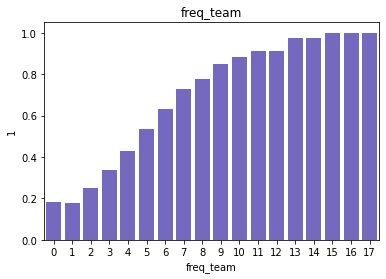

In [35]:
#create stacked bar chart
fig= sns.barplot(data = plot, x='freq_team',y=1,color = 'slateblue')
fig.set(title='freq_team')

In [36]:
plot = pd.crosstab(pentathlon_nptb.freq_backcountry, pentathlon_nptb.buyer_yes,normalize='index').reset_index()

[Text(0.5, 1.0, 'freq_backcountry')]

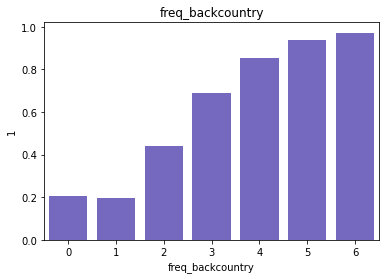

In [37]:
#create stacked bar chart
fig= sns.barplot(data = plot, x='freq_backcountry',y=1,color = 'slateblue')
fig.set(title='freq_backcountry')

In [38]:
plot = pd.crosstab(pentathlon_nptb.freq_winter, pentathlon_nptb.buyer_yes,normalize='index').reset_index()

[Text(0.5, 1.0, 'freq_winter')]

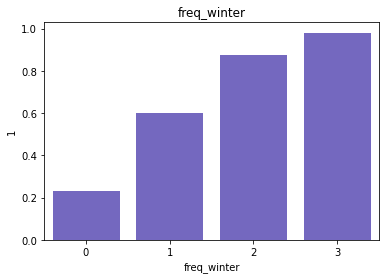

In [39]:
#create stacked bar chart
fig= sns.barplot(data = plot, x='freq_winter',y=1,color = 'slateblue')
fig.set(title='freq_winter')

In [40]:
plot = pd.crosstab(pentathlon_nptb.freq_racquet, pentathlon_nptb.buyer_yes,normalize='index').reset_index()

[Text(0.5, 1.0, 'freq_racquet')]

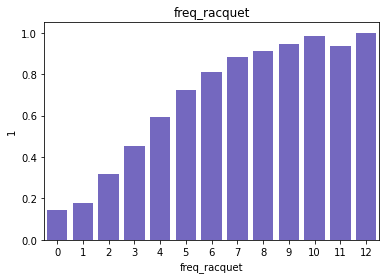

In [41]:
#create stacked bar chart
fig= sns.barplot(data = plot, x='freq_racquet',y=1,color = 'slateblue')
fig.set(title='freq_racquet')

### Possible feature improvements

- income and education: account for multicollinearity
- children: create bins, transfer into category (should help reduce noise)

## 1.2 transform data format

In [42]:
pentathlon_nptb['training']= rsm.ifelse(pentathlon_nptb['training']==1,1,rsm.ifelse(pentathlon_nptb['training']==0,0,2))
pentathlon_nptb["cweight"] = rsm.ifelse(pentathlon_nptb.buyer == "yes", 1, 99)

In [43]:
train = pentathlon_nptb.query("training==1")
test = pentathlon_nptb.query("training==0")
repre = pentathlon_nptb.query("training==2")

In [44]:
pentathlon_nptb_std = pentathlon_nptb.copy()

In [45]:
to_std = ['income', 'children', 'freq_endurance', 'freq_strength',
       'freq_water', 'freq_team', 'freq_backcountry', 'freq_winter',
       'freq_racquet']
exl = rsm.setdiff(pentathlon_nptb_std.columns,to_std)

In [46]:
pentathlon_nptb_std= rsm.scale_df(pentathlon_nptb_std, sf=1, train=pentathlon_nptb_std.training == 1,excl=exl, wt = pentathlon_nptb_std['cweight'])

In [47]:
train_std = pentathlon_nptb_std.query("training==1")
test_std = pentathlon_nptb_std.query("training==0")
repre_std = pentathlon_nptb_std.query("training==2")

## 1.3 Model

## 1.3.1 Build Model

In [48]:
pentathlon_nptb['message'].value_counts() # current value counts

team           29046
racquet        28722
winter         28701
backcountry    28564
water          28402
strength       28382
endurance      28183
Name: message, dtype: int64

### with weight and standardalize

In [49]:
lr_std = smf.glm(
    formula="buyer_yes ~ message + age + gender + income + education + children + \
             freq_endurance + freq_strength + freq_water + freq_team + freq_backcountry + freq_winter + freq_racquet+ \
             message:age + message:gender + message:income + message:education + message:children +\
             message:freq_endurance + message:freq_strength + message:freq_water + message:freq_team + \
             message:freq_backcountry + message:freq_winter + message:freq_racquet",
    family=Binomial(link=logit()),
    data=train_std,
    freq_weights=train_std["cweight"],
).fit(cov_type="HC1")

In [50]:
pred_train = pd.DataFrame().assign(
    actual=train_std.buyer_yes, pred=lr_std.predict(train_std) ## drop first column which is useless
)
pred_test = pd.DataFrame().assign(actual=test_std.buyer_yes, pred=lr_std.predict(test_std))

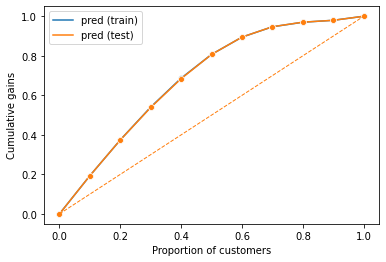

In [51]:
dct = {"train": pred_train, "test": pred_test}
fig = rsm.gains_plot(dct, "actual", 1, "pred").legend(title=None)

The training and testing data have a similar gain plot, so the model doesn't face the problem of overfitting

In [52]:
y_score = lr_std.predict(test_std)
auc = roc_auc_score(test_std.buyer_yes,y_score)
auc

0.8804006355555556

In [53]:
rsm.or_ci(lr_std).iloc[list(range(10))+[34,41,48,55,62,69,76,83,90]]

,index,OR,OR%,2.5%,97.5%,p.values,
1,message[T.strength],0.641,-35.9%,0.526,0.782,< .001,***
2,message[T.water],0.599,-40.1%,0.492,0.730,< .001,***
3,message[T.team],0.605,-39.5%,0.497,0.737,< .001,***
4,message[T.backcountry],0.827,-17.3%,0.681,1.004,0.055,.
5,message[T.winter],0.632,-36.8%,0.517,0.772,< .001,***
6,message[T.racquet],0.847,-15.3%,0.692,1.037,0.108,
7,age[T.30 to 44],1.972,97.2%,1.782,2.183,< .001,***
8,age[T.45 to 59],2.077,107.7%,1.870,2.308,< .001,***
9,age[T.>= 60],1.080,8.0%,0.947,1.232,0.248,
10,gender[T.F],0.690,-31.0%,0.645,0.738,< .001,***


## 1.3.2 prediction

In [54]:
pentathlon_nptb_std["p_random"] = lr_std.predict(pentathlon_nptb_std)
pentathlon_nptb_std["p_team"] = lr_std.predict(pentathlon_nptb_std.assign(message="team"))
pentathlon_nptb_std["p_racquet"] = lr_std.predict(pentathlon_nptb_std.assign(message="racquet"))
pentathlon_nptb_std["p_winter"] = lr_std.predict(pentathlon_nptb_std.assign(message="winter"))
pentathlon_nptb_std["p_back"] = lr_std.predict(pentathlon_nptb_std.assign(message="backcountry"))
pentathlon_nptb_std["p_water"] = lr_std.predict(pentathlon_nptb_std.assign(message="water"))
pentathlon_nptb_std["p_strength"] = lr_std.predict(pentathlon_nptb_std.assign(message="strength"))
pentathlon_nptb_std["p_endurance"] = lr_std.predict(pentathlon_nptb_std.assign(message="endurance"))

In [55]:
pentathlon_nptb_std["to_message"] = (
    pentathlon_nptb_std[["p_team", "p_racquet", "p_winter", "p_back", "p_water", "p_strength", "p_endurance"]]
    .idxmax(axis=1)
    .str.replace("p_team", "team")
    .replace("p_racquet", "racquet")
    .replace("p_winter", "winter")
    .replace("p_back", "backcountry")
    .replace("p_water", "water")
    .replace("p_strength", "strength")
    .replace("p_endurance", "endurance")
)
pentathlon_nptb_std


,custid,buyer,total_os,message,age,gender,income,education,children,freq_endurance,...,cweight,p_random,p_team,p_racquet,p_winter,p_back,p_water,p_strength,p_endurance,to_message
0,U45198803,no,0.0,endurance,30 to 44,M,-1.344562,14,0.809804,-0.636716,...,99,0.002200,0.002404,0.001930,0.001840,0.001525,0.002530,0.002491,0.002200,water
1,U22197752,no,0.0,backcountry,45 to 59,F,-0.460106,44,-1.109431,0.810590,...,99,0.006291,0.005931,0.004949,0.004404,0.006291,0.006965,0.004228,0.006259,water
2,U83874832,no,0.0,backcountry,45 to 59,M,0.129531,24,-0.256438,-0.636716,...,99,0.006381,0.006358,0.005794,0.003937,0.006381,0.005057,0.004200,0.006276,backcountry
3,U19423462,no,0.0,winter,45 to 59,F,0.129531,26,0.383307,0.086937,...,99,0.003548,0.003037,0.002831,0.003548,0.003715,0.004073,0.003333,0.004763,endurance
4,U23888305,no,0.0,winter,30 to 44,M,-0.460106,22,0.170059,0.086937,...,99,0.004178,0.004534,0.004410,0.004178,0.003614,0.004843,0.005803,0.004756,strength
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,U54280824,yes,448.0,backcountry,45 to 59,F,2.193262,55,0.596556,-0.636716,...,1,0.027302,0.045483,0.026445,0.089961,0.027302,0.046097,0.025438,0.040084,winter
199996,U99229186,yes,52.0,strength,45 to 59,M,0.424350,53,-0.043189,0.086937,...,1,0.025599,0.024537,0.025793,0.019092,0.022117,0.032335,0.025599,0.043939,endurance
199997,U83335706,no,0.0,racquet,>= 60,F,0.129531,33,2.729039,0.086937,...,99,0.006428,0.010154,0.006428,0.006863,0.004997,0.014491,0.007140,0.009415,water
199998,U33721691,no,0.0,strength,30 to 44,M,-1.344562,10,0.809804,-0.636716,...,99,0.001861,0.001727,0.001498,0.001442,0.001207,0.001953,0.001861,0.001814,water


In [56]:
pd.crosstab(index=pentathlon_nptb_std.to_message, columns="count").apply(rsm.format_nr)

col_0,count
to_message,
backcountry,"8,199"
endurance,"77,291"
racquet,"5,573"
strength,"46,464"
team,"22,312"
water,"32,850"
winter,"7,311"


In [57]:
pentathlon_nptb_std["p_targeti"] = pentathlon_nptb_std[["p_team", "p_racquet", "p_winter", "p_back", "p_water", "p_strength", "p_endurance"]].max(axis=1)

In [58]:
pentathlon_nptb_std[["p_team", "p_racquet", "p_winter", "p_back", "p_water", "p_strength", "p_endurance", "p_targeti"]].agg(np.mean).sort_values(
    ascending=False
).apply(rsm.format_nr, perc=True)

p_targeti      4.41%
p_strength     3.69%
p_endurance    3.62%
p_winter       3.28%
p_racquet      2.99%
p_water        2.94%
p_back         2.91%
p_team         2.84%
dtype: object

In [59]:
pd.DataFrame(
    pentathlon_nptb_std.loc[pentathlon_nptb_std.representative==1,'to_message']
    .value_counts(normalize=True,ascending=False)
    .apply(rsm.format_nr,perc=True)
)

,to_message
endurance,40.62%
strength,20.49%
water,18.55%
team,10.95%
backcountry,4.35%
racquet,3.21%
winter,1.83%


- Messages focused on Endurance lead to the highest probability of purchase in over 40% of cases.
- Predicted purchase probability for Winter and Racquet is seldom highest

## 1.3.3 expected profit

We have two methods to predict the profit, the first one is to calculate the average ordersize for each category and another one is to use a machine learning models to make a prediction. 

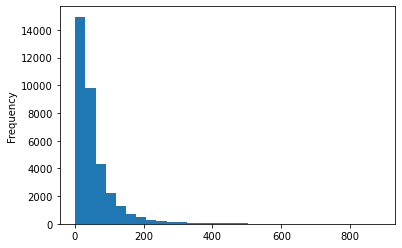

In [60]:
## check order size distribution
fig = train_std.query("buyer=='yes'").total_os.plot.hist(bins=30)

From the histogram above, we figure out that the toal_os is highly right skewed, therefore, we need to transform the ordersize into log

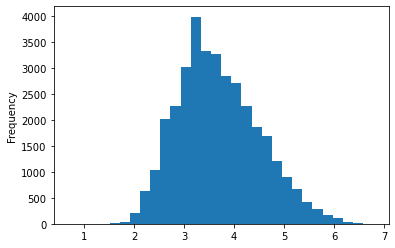

In [61]:
fig = np.log(
    train_std.query("buyer=='yes'").total_os
).plot.hist(bins=30)

After transformation, the distribution looks well, therefore we will use log ordersize as the dependent variable

In [62]:
pentathlon_nptb_std['os_log'] = np.log(pentathlon_nptb_std['total_os'])

/Users/hanqingdou/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [63]:
pentathlon_nptb_std['os_log'].replace([np.inf, -np.inf], 0, inplace=True)

In [64]:
nn_col = pentathlon_nptb_std.loc[:,'message':'freq_racquet'].columns
other = rsm.setdiff(nn_col,['gender','age','message'])

In [65]:
dummy = pd.get_dummies(pentathlon_nptb_std[["gender",'age','message']], drop_first=True)

In [66]:
new_col = other+list(dummy.columns)

In [67]:
pentathlon_nptb_std2 = pd.concat([pentathlon_nptb_std,dummy],axis=1)

In [68]:
train = pentathlon_nptb_std2.query("training ==1")
test = pentathlon_nptb_std2.query("training ==0")

In [69]:
X_train = train[new_col]
X_test = test[new_col]

y_train = train['os_log']
y_test = test['os_log']

In [70]:
def nn(X, y, hlsizes=(1,), alpha=0.0001, max_iter=10000):
    return MLPRegressor(
        activation="tanh",
        solver="lbfgs",
        hidden_layer_sizes=hlsizes,
        alpha=alpha,
        random_state=1234,
        max_iter=max_iter).fit(X, y)

In [71]:
reg = nn(X_train,y_train)

In [ ]:
hls = [(1,), (2,), (3,), (3, 3), (4, 2), (5, 5)]
reg_scorer = {
    'r2':metrics.make_scorer(metrics.r2_score),
    'mse':metrics.make_scorer(metrics.mean_squared_error),
}

param_grid = {"hidden_layer_sizes": hls,
             "alpha":[0.001,0.01,0.05,0.1,0.5]}

reg_cv = GridSearchCV(   
    reg,param_grid,scoring=reg_scorer, cv=5, n_jobs=4,refit='r2',verbose=5
).fit(X_train,y_train)

In [175]:
rsm.save_state({"reg_cv":reg_cv},path = 'reg_cv.pkl')

In [83]:
reg_cv = pd.read_pickle('reg_cv.pkl')

In [84]:
reg_cv = reg_cv['reg_cv']

#### Predict order size for 7 messages using NN

In [78]:
levels = pentathlon_nptb_std2.message.cat.categories

def assigner(df,message):
    df=df.copy()
    for l in levels[1:]:
        df['message_'+l] = rsm.ifelse(l == message,1,0)
    return df

In [79]:
Xs = pentathlon_nptb_std2[new_col]

In [85]:
pentathlon_nptb_std2 = pentathlon_nptb_std2.assign(
    os_random = reg_cv.predict(Xs),
    os_endurance = reg_cv.predict(assigner(Xs,'endurance')),
    os_strength= reg_cv.predict(assigner(Xs,'strength')),
    os_water= reg_cv.predict(assigner(Xs,'water')),
    os_team= reg_cv.predict(assigner(Xs,'team')),
    os_backcountry= reg_cv.predict(assigner(Xs,'backcountry')),
    os_winter= reg_cv.predict(assigner(Xs,'winter')),
    os_racquet= reg_cv.predict(assigner(Xs,'racquet')),
)

In [86]:
pentathlon_nptb_std2 = pentathlon_nptb_std2.assign(
    ep_random = pentathlon_nptb_std2.p_random * np.exp(pentathlon_nptb_std2.os_random) *0.4,
    ep_endurance = pentathlon_nptb_std2.p_endurance * np.exp(pentathlon_nptb_std2.os_endurance) *0.4,
    ep_strength = pentathlon_nptb_std2.p_strength * np.exp(pentathlon_nptb_std2.os_strength) *0.4,
    ep_water = pentathlon_nptb_std2.p_water * np.exp(pentathlon_nptb_std2.os_water) *0.4,
    ep_team = pentathlon_nptb_std2.p_team * np.exp(pentathlon_nptb_std2.os_team) *0.4,
    ep_backcountry = pentathlon_nptb_std2.p_back * np.exp(pentathlon_nptb_std2.os_backcountry) *0.4,
    ep_winter = pentathlon_nptb_std2.p_winter * np.exp(pentathlon_nptb_std2.os_winter) *0.4,
    ep_racquet = pentathlon_nptb_std2.p_racquet * np.exp(pentathlon_nptb_std2.os_racquet) *0.4,
)

In [87]:
pentathlon_nptb_std2["to_message_ep"] = (
    pentathlon_nptb_std2[["ep_team", "ep_racquet", "ep_winter", "ep_backcountry", "ep_water", "ep_strength", "ep_endurance"]]
    .idxmax(axis=1)
    .str.replace("ep_team", "team")
    .replace("ep_racquet", "racquet")
    .replace("ep_winter", "winter")
    .replace("ep_backcountry", "backcountry")
    .replace("ep_water", "water")
    .replace("ep_strength", "strength")
    .replace("ep_endurance", "endurance")
)

In [88]:
pentathlon_nptb_std2["ep_targeti"] = pentathlon_nptb_std2[["ep_team", "ep_racquet", "ep_winter", "ep_backcountry", "ep_water", "ep_strength", "ep_endurance"]].max(axis=1)

In [89]:
pd.DataFrame(
    pentathlon_nptb_std2.loc[pentathlon_nptb_std2.representative==1,'to_message']
    .value_counts(normalize=True,ascending=False)
    .apply(rsm.format_nr,perc=True)
)

,to_message
endurance,40.62%
strength,20.49%
water,18.55%
team,10.95%
backcountry,4.35%
racquet,3.21%
winter,1.83%


In [90]:
pd.DataFrame(
    pentathlon_nptb_std2.loc[pentathlon_nptb_std2.representative==1,'to_message_ep']
    .value_counts(normalize=True,ascending=False)
    .apply(rsm.format_nr,perc=True)
)

,to_message_ep
endurance,41.79%
strength,21.75%
water,19.87%
team,8.29%
backcountry,3.6%
racquet,2.81%
winter,1.88%


### Policy Weakness

>The propose allocating messages for the next month based on a customer's response to her two 'best' messages. However, in this proposal, a customer is never sent messages other than her two best messages. Overtime, this makes it difficult to estimate what a customer's response would be to messages other than the two 'best' messages. If thoise customers get tired of their 'best' messages, that will provide even less justification to switch messages, even though that might be the best thing to do.